##pip, import


In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from sklearn.utils import check_random_state


In [8]:
plt.style.use("ggplot")
plt.rcParams['text.usetex'] = True
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]

## function


In [9]:
def sharpe_ratio(
    env_name, 
    topk_metrics_dict, 
    sharpe_log_scale=False, 
    best_log_scale=False, 
    std_log_scale=False, 
    on_policy_value=-38, 
    sharpe_legend="lower right",
    best_legend="lower right",
    std_legend="lower right",
    max_topk=10, 
    alpha=0.05
    ):

  estimator_list = ['dm', 'snpdis', 'sndr', 'sam_snis']
  estimator_name = ['DM', 'PDIS', 'DR', 'MIS']
  random_ = check_random_state(12345)

  lower_sharpe = np.zeros(max_topk)
  upper_sharpe = np.zeros(max_topk)
  lower_std = np.zeros(max_topk)
  upper_std = np.zeros(max_topk)
  lower_best = np.zeros(max_topk)
  upper_best = np.zeros(max_topk)
  n_bootstrap_samples = 1000
  colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
  n_colors = len(colors)

  fig = plt.figure(constrained_layout=True, figsize=(12.0, 3.5))
  gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3.8,6.2])

  gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
  ax00 = fig.add_subplot(gs00[0])

  for i, estimator in enumerate(estimator_list):
    metric_dict = topk_metrics_dict[estimator]

    ax00.plot(
        np.arange(2, max_topk + 1),
        metric_dict['sharpe_ratio'][1:].mean(axis=1),
        color=colors[i],
        marker=markers[i],
        label=estimator_name[i],
    )

    ax00.plot(
        np.arange(2, max_topk + 1),
        np.zeros((max_topk - 1, )),
        color="black",
        linewidth=0.5,
    )

    for topk in range(1, max_topk):
      samples = metric_dict['sharpe_ratio'][topk]
      boot_samples = [
          np.mean(random_.choice(samples, size=samples.shape[0]))
          for i in range(n_bootstrap_samples)
      ]
      lower_sharpe[topk] = np.percentile(boot_samples, 100 * (alpha / 2))
      upper_sharpe[topk] = np.percentile(boot_samples, 100 * (1.0 - alpha / 2))

      ax00.fill_between(
          np.arange(2, max_topk + 1),
          lower_sharpe[1:],
          upper_sharpe[1:],
          color=colors[i % n_colors],
          alpha=0.03,
      )
    if sharpe_log_scale:
        ax00.set_yscale('log')
    ax00.set_title(f"Sharpe ratio")
    ax00.set_xlabel("\# of policies deployed", fontsize=14)
    ax00.set_ylabel(f"Sharpe ratio", fontsize=14)
    ax00.legend(loc=sharpe_legend)

  gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[1,4])
  gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs01[1], wspace=0.2)
  ax01 = fig.add_subplot(gs02[0])
  ax02 = fig.add_subplot(gs02[1])

  for i, estimator in enumerate(estimator_list):
    metric_dict = topk_metrics_dict[estimator]

    ax01.plot(
        np.arange(2, max_topk + 1),
        metric_dict["best"][1:].mean(axis=1) - (on_policy_value),
        color=colors[i],
        marker=markers[i],
        label=estimator_name[i],
    )

    ax02.plot(
        np.arange(2, max_topk + 1),
        metric_dict["std"][1:].mean(axis=1),
        color=colors[i],
        marker=markers[i],
        label=estimator_name[i],
    )
  
    for topk in range(1, max_topk):
      samples_best = metric_dict['best'][topk] - (on_policy_value)
      boot_samples_best = [
          np.mean(random_.choice(samples_best, size=samples_best.shape[0]))
          for i in range(n_bootstrap_samples)
      ]
      lower_best[topk] = np.percentile(boot_samples_best, 100 * (alpha / 2))
      upper_best[topk] = np.percentile(boot_samples_best, 100 * (1.0 - alpha / 2))

      ax01.fill_between(
          np.arange(2, max_topk + 1),
          lower_best[1:],
          upper_best[1:],
          color=colors[i % n_colors],
          alpha=0.03,
      )

      samples_std = metric_dict['std'][topk]
      boot_samples_std = [
          np.mean(random_.choice(samples_std, size=samples_std.shape[0]))
          for i in range(n_bootstrap_samples)
      ]
      lower_std[topk] = np.percentile(boot_samples_std, 100 * (alpha / 2))
      upper_std[topk] = np.percentile(boot_samples_std, 100 * (1.0 - alpha / 2))

      ax02.fill_between(
          np.arange(2, max_topk + 1),
          lower_std[1:],
          upper_std[1:],
          color=colors[i % n_colors],
          alpha=0.03,
      )

  if best_log_scale:
      ax01.set_yscale('log')
  ax01.set_title(f"numerator (best@$k$ - $J(\pi_b)$)")
  ax01.set_xlabel("\# of policies deployed", fontsize=14)
  ax01.set_ylabel(f"best@$k$ - $J(\pi_b)$", fontsize=14)
  ax01.legend(loc=best_legend)

  if std_log_scale:
      ax02.set_yscale('log')
  ax02.set_title(f"denominator (std@$k$)")
  ax02.set_xlabel("\# of policies deployed", fontsize=14)
  ax02.set_ylabel(f"std@$k$", fontsize=14)
  # ax02.set_ylim(10, 30)
  ax02.legend(loc=std_legend)

  fig.tight_layout()
  fig.savefig(f"sharpe_ratio_{env_name}.png", dpi=300, bbox_inches="tight")

In [10]:
def relative_conventional_metrics(env_name, conventional_metrics_dict, behavior_name):
  n_dataset = 10
  estimator_list = ['dm', 'snpdis', 'sndr', 'sam_snis']
  
  regret = {j: {k: 0 for k in estimator_list} for j in range(n_dataset)}
  mse = {j: {k: 0 for k in estimator_list}for j in range(n_dataset)}
  rank_cc = {j: {k: 0 for k in estimator_list}for j in range(n_dataset)}
  mean_true_policy_value = np.mean(conventional_metrics_dict[behavior_name][0][estimator_list[0]]['true_policy_value'])

  for i in range(n_dataset):
    for estimator in estimator_list:
      regret[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['regret'][0]/abs(mean_true_policy_value)
      mse[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['mean_squared_error']/(mean_true_policy_value**2)
      rank_cc[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['rank_correlation'][0]

  regret_df = pd.DataFrame(regret)
  regret_df['mean'] = regret_df.mean(axis=1)
  regret_df['std'] = regret_df.std(axis=1)

  rank_cc_df = pd.DataFrame(rank_cc)
  rank_cc_df['mean'] = rank_cc_df.mean(axis=1)
  rank_cc_df['std'] = rank_cc_df.std(axis=1)

  mse_df = pd.DataFrame(mse)
  mse_df['mean'] = mse_df.mean(axis=1)
  mse_df['std'] = mse_df.std(axis=1)

  return regret_df, rank_cc_df, mse_df 


In [11]:
def conventional_metrics(env_name, conventional_metrics_dict, behavior_name):
  n_dataset = 10
  estimator_list = ['dm', 'snpdis', 'sndr', 'sam_snis']
  
  regret = {j: {k: 0 for k in estimator_list} for j in range(n_dataset)}
  mse = {j: {k: 0 for k in estimator_list}for j in range(n_dataset)}
  rank_cc = {j: {k: 0 for k in estimator_list}for j in range(n_dataset)}

  for i in range(n_dataset):
    for estimator in estimator_list:
      regret[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['regret'][0]
      mse[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['mean_squared_error']
      rank_cc[i][estimator] = conventional_metrics_dict[behavior_name][i][estimator]['rank_correlation'][0]

  regret_df = pd.DataFrame(regret)
  regret_df['mean'] = regret_df.mean(axis=1)
  regret_df['std'] = regret_df.std(axis=1)

  rank_cc_df = pd.DataFrame(rank_cc)
  rank_cc_df['mean'] = rank_cc_df.mean(axis=1)
  rank_cc_df['std'] = rank_cc_df.std(axis=1)

  mse_df = pd.DataFrame(mse)
  mse_df['mean'] = mse_df.mean(axis=1)
  mse_df['std'] = mse_df.std(axis=1)

  return regret_df, rank_cc_df, mse_df 


##Hopper


In [12]:
env_name='Hopper'

###sharpe_ratio


In [59]:
with open("logs/results/raw/topk_metrics_dict_Hopper-v4_sac_gauss_1.0_10.pkl", "rb") as f:
# with open("raw/topk_metrics_dict_Hopper-v4_sac_gauss_1.5_10.pkl", "rb") as f:
    topk_metrics_dict_Hopper = pickle.load(f)

In [ ]:
topk_metrics_dict_Hopper

<ipython-input-9-d1ecd06333f8>:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


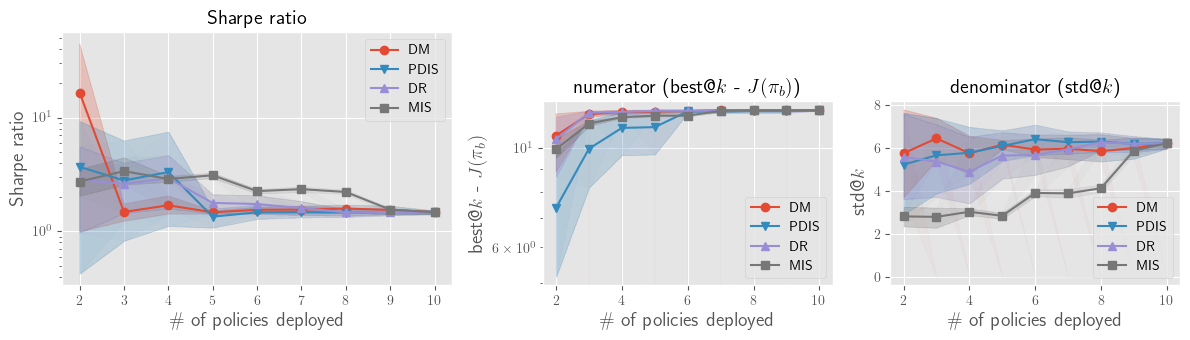

In [61]:
sharpe_ratio('Hopper', topk_metrics_dict_Hopper, on_policy_value=40, max_topk=10, sharpe_legend='upper right', sharpe_log_scale=True, best_log_scale=True)
# sharpe_ratio('Hopper', topk_metrics_dict_Hopper, max_topk=10, sharpe_legend='upper right', sharpe_log_scale=True, best_log_scale=True, std_log_scale=True)

### conventional_metrics



In [50]:
with open("logs/results/raw/conventional_metrics_dict_Hopper-v4_sac_gauss_1.0_10.pkl", "rb") as f:
    conventional_metrics_dict_Hopper = pickle.load(f)
# with open("raw/conventional_metrics_dict_Hopper-v4_sac_gauss_1.5_10.pkl", "rb") as f:

In [55]:
regret_df, rank_cc_df, mse_df  = relative_conventional_metrics('Hopper', conventional_metrics_dict_Hopper, 'sac_gauss_1.0')
# regret_df, rank_cc_df, mse_df  = relative_conventional_metrics('Hopper', conventional_metrics_dict_Hopper, 'sac_gauss_1.5')

In [56]:
regret_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.268912,0.332802,0.168797,0.007946,0.163306,0.009276,0.002312,0.007360,0.132336,0.152275,0.124532,0.111382
snpdis,0.296504,0.332802,0.000000,0.000000,0.007550,0.320363,0.181224,0.390903,0.164863,0.273532,0.196774,0.142059
sndr,0.189708,0.000000,0.287749,0.197970,0.387449,0.163717,0.047013,0.390903,0.007718,0.009955,0.168218,0.143910
sam_snis,0.051879,0.049929,0.070160,0.063597,0.052585,0.058602,0.047013,0.068560,0.050161,0.064891,0.057738,0.008074


In [57]:
rank_cc_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.248485,0.236364,0.418182,0.575758,0.212121,0.636364,0.175758,0.454545,0.151515,0.090909,0.320000,0.178511
snpdis,-0.260606,-0.781818,0.163636,0.842424,0.163636,-0.224242,-0.236364,-0.442424,-0.272727,-0.284848,-0.133333,0.414972
sndr,0.430303,0.709091,-0.115152,0.466667,0.018182,0.127273,0.381818,-0.018182,0.612121,0.527273,0.313939,0.273639
sam_snis,0.418182,0.478788,0.515152,0.575758,0.478788,0.406061,0.478788,0.503030,0.490909,0.515152,0.486061,0.046061


In [58]:
mse_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.028719,0.030331,0.028049,0.025418,0.030167,0.026227,0.033185,0.028721,0.029543,0.026054,0.028641,0.002234
snpdis,0.037621,0.041226,0.044883,0.008753,0.029948,0.042325,0.032269,0.025389,0.047600,0.032198,0.034221,0.010825
sndr,0.070428,0.046099,0.117222,0.079179,0.116458,0.053564,0.051204,0.065322,0.061935,0.086946,0.074836,0.024099
sam_snis,0.016777,0.019558,0.017845,0.019394,0.019772,0.019914,0.020911,0.019404,0.020659,0.017312,0.019155,0.001317


## reacher

In [21]:
# with open("input_dict_Reacher-v4_sac_gauss_0.7_12.pkl", "rb") as f:
#     input_dict_Reacher = pickle.load(f)

###sharpe_ratio


In [22]:
with open("logs/results/raw/topk_metrics_dict_Reacher-v4_sac_gauss_0.7_10.pkl", "rb") as f:
    topk_metrics_dict_Reacher = pickle.load(f)

In [23]:
topk_metrics_dict_Reacher

{'dm': {'k-th': array([[-23.78421197, -38.47546795, -39.16203713, -38.84116393,
          -39.71734594, -39.26303678, -38.9014756 , -38.8918808 ,
          -37.679016  , -38.1453309 ],
         [-39.17258099, -40.65679852, -38.9567363 , -40.30639935,
          -39.54303654, -58.50681322, -57.93636426, -14.66315241,
          -42.71655688, -39.02421871],
         [-14.64194619, -14.62327639, -14.4811666 , -45.39671221,
          -14.74633529, -14.84336131, -14.86864818, -14.92705786,
          -14.38294399, -44.14192565],
         [-58.94227237, -23.96353967, -59.10988112, -17.83058585,
          -17.65114207, -39.30708489, -14.80939   , -39.40401001,
          -14.6752759 , -58.94025604],
         [-17.54358564, -58.15386663, -14.67604103, -59.59078419,
          -43.29470045, -44.05105684, -39.34231976, -18.6127531 ,
          -39.97235772, -14.73079893],
         [-64.09708514, -42.32705091, -17.98360613, -62.83976046,
          -14.53237315, -17.52793724, -17.90215408, -61.86949667,

<ipython-input-9-d1ecd06333f8>:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


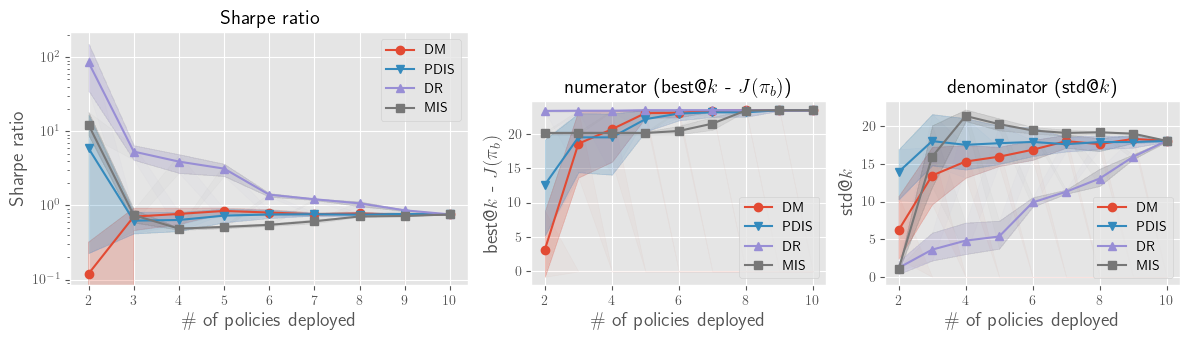

In [24]:
sharpe_ratio('Reacher', topk_metrics_dict_Reacher, max_topk=10, sharpe_log_scale=True, sharpe_legend='upper right')

### conventional_metrics



In [25]:
with open("raw/conventional_metrics_dict_Reacher-v4_sac_gauss_0.7_10.pkl", "rb") as f:
    conventional_metrics_dict_Reacher = pickle.load(f)

In [26]:
regret_df, rank_cc_df, mse_df  = relative_conventional_metrics('Reacher', conventional_metrics_dict_Reacher, 'sac_gauss_0.7')

In [27]:
regret_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.273512,0.713593,0.738385,0.726158,0.753467,0.744617,0.720770,0.724858,0.696956,0.711354,0.680367,0.136535
snpdis,1.479565,0.778853,0.732243,0.007646,0.260620,0.014046,0.733959,1.412287,0.765566,0.010854,0.619564,0.517779
sndr,0.003504,0.004609,0.000000,0.007646,0.006401,0.014046,0.000000,0.000000,0.102177,0.000000,0.013838,0.029758
sam_snis,0.086809,0.086856,0.104784,0.097579,0.093305,0.094362,0.092527,0.118161,0.102177,0.114905,0.099147,0.010283


In [28]:
rank_cc_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.078788,0.006061,0.042424,-0.442424,0.187879,-0.272727,0.127273,0.442424,0.248485,-0.163636,0.025455,0.246463
snpdis,0.163636,0.272727,0.333333,0.333333,-0.442424,0.381818,0.054545,-0.369697,-0.624242,0.163636,0.026667,0.348411
sndr,0.975758,0.854545,0.842424,0.951515,0.927273,0.757576,0.951515,0.939394,0.818182,0.915152,0.893333,0.067444
sam_snis,-0.103030,0.127273,-0.236364,-0.115152,-0.200000,-0.103030,-0.127273,-0.066667,-0.115152,-0.066667,-0.100606,0.091481


In [29]:
mse_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.581873,0.595173,0.598078,0.615088,0.608563,0.609540,0.600949,0.583498,0.602268,0.604105,0.599914,0.010211
snpdis,0.311747,0.284735,0.294431,0.298158,0.324061,0.274892,0.281836,0.311294,0.373057,0.285437,0.303965,0.027321
sndr,0.182776,0.217587,0.322732,0.322266,0.338902,0.320924,0.356083,0.176559,0.314144,0.318231,0.287021,0.063818
sam_snis,0.298293,0.286676,0.289408,0.304014,0.295418,0.298302,0.286216,0.288403,0.302144,0.292501,0.294138,0.006118


##InvertedPendulum


###sharpe_ratio


In [30]:
with open("logs/resultsraw/topk_metrics_dict_InvertedPendulum-v4_sac_gauss_1.5_10.pkl", "rb") as f:
    topk_metrics_dict_InvertedPendulum = pickle.load(f)

<ipython-input-9-d1ecd06333f8>:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


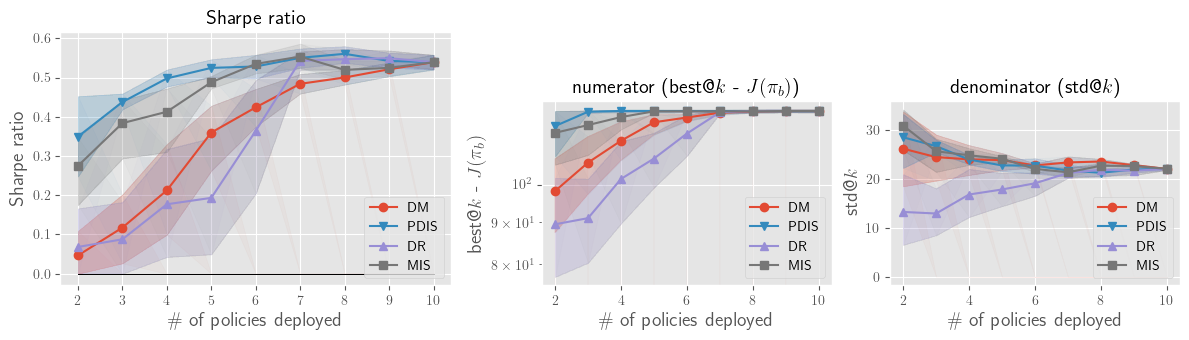

In [31]:
sharpe_ratio('InvertedPendulum', topk_metrics_dict_InvertedPendulum, max_topk=10,  best_log_scale=True)

### conventional_metrics



In [32]:
with open("logs/results/raw/conventional_metrics_dict_InvertedPendulum-v4_sac_gauss_1.5_10.pkl", "rb") as f:
    conventional_metrics_dict_InvertedPendulum = pickle.load(f)

In [33]:
#  conventional_metrics_dict_InvertedPendulum

In [34]:
regret_df, rank_cc_df, mse_df  = relative_conventional_metrics('InvertedPendulum', conventional_metrics_dict_InvertedPendulum, 'sac_gauss_1.5')

In [35]:
regret_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,1.241306,1.263114,0.029471,0.468191,1.238556,1.171166,1.26115,1.025188,0.386459,0.460922,0.854552,0.443027
snpdis,0.000000,0.937168,0.029471,0.855829,0.954261,0.000000,0.95210,0.000000,0.957994,0.000000,0.468682,0.463662
sndr,0.837950,0.886479,0.832842,0.944045,1.033832,0.000000,1.26115,1.214390,0.957994,0.882156,0.885084,0.326974
sam_snis,0.919486,0.937168,0.978820,0.944045,0.954261,0.941098,0.95210,0.964871,0.957994,0.460922,0.901077,0.147517


In [36]:
rank_cc_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,-0.090909,-0.454545,-0.006061,-0.018182,-0.309091,-0.200000,-0.430303,-0.466667,-0.163636,-0.321212,-0.246061,0.166798
snpdis,0.430303,0.321212,0.660606,0.575758,0.078788,0.539394,0.187879,-0.030303,-0.054545,0.624242,0.333333,0.259065
sndr,0.175758,-0.345455,0.163636,-0.515152,-0.527273,-0.042424,-0.309091,-0.636364,-0.696970,0.575758,-0.215758,0.396793
sam_snis,0.503030,0.442424,0.587879,0.466667,0.430303,0.212121,0.490909,0.587879,-0.345455,-0.151515,0.322424,0.305226


In [37]:
mse_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.389509,0.457384,0.408454,0.431666,0.458966,0.408403,0.409464,0.434287,0.393453,0.431866,0.422345,0.023141
snpdis,0.568736,0.646106,0.523752,0.650657,0.659957,0.497348,0.691865,0.812038,0.342831,0.153300,0.554659,0.180037
sndr,0.916300,1.526357,0.373718,1.286094,1.455741,1.316435,0.977550,1.774985,1.164753,1.603664,1.239560,0.385323
sam_snis,0.352865,0.402570,0.389880,0.399093,0.380273,0.357650,0.369376,0.376976,0.356386,0.382707,0.376778,0.016705


##Acrobot

In [38]:
env_name='Acrobot'

###sharpe_ratio


In [39]:
with open("logs/results/raw/topk_metrics_dict_Acrobot_ddqn_softmax_5.0_10.pkl", "rb") as f:
    topk_metrics_dict_Acrobot = pickle.load(f)

<ipython-input-9-d1ecd06333f8>:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


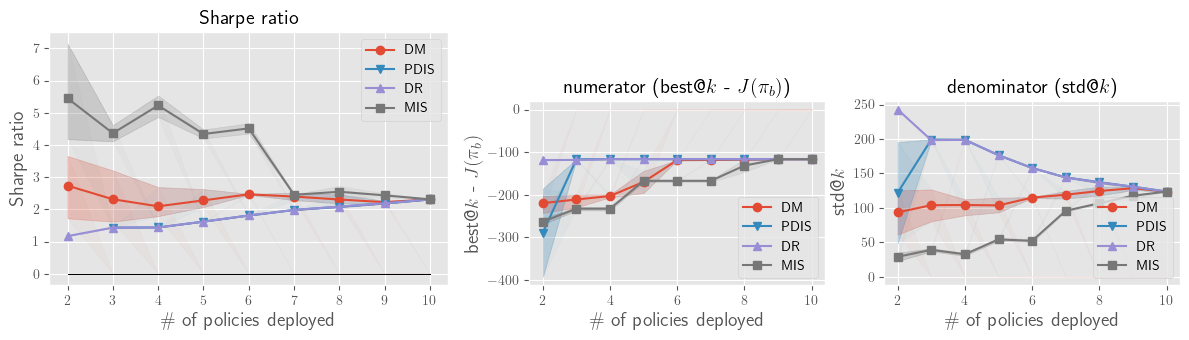

In [40]:
sharpe_ratio('Acrobot', topk_metrics_dict_Acrobot, max_topk=10, sharpe_legend='upper right')

### conventional_metrics



In [41]:
with open("logs/results/raw/conventional_metrics_dict_Acrobot_ddqn_softmax_5.0_10.pkl", "rb") as f:
    conventional_metrics_dict_Acrobot = pickle.load(f)

In [42]:
regret_df, rank_cc_df, mse_df  = relative_conventional_metrics('Acrobot', conventional_metrics_dict_Acrobot, 'ddqn_softmax_5.0')

In [43]:
regret_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.312789,0.295410,1.147811,0.495517,0.561378,0.268228,0.489868,0.297237,0.278097,0.615177,0.476151,0.255363
snpdis,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,0.000000,1.147811,1.147811,1.147811,1.033030,0.344343
sndr,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,1.147811,0.000000
sam_snis,0.511268,0.532003,0.518147,0.472855,0.476444,0.492427,0.445540,0.495252,0.516253,0.474915,0.493510,0.025080


In [44]:
rank_cc_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,-0.224242,-0.357576,-0.430303,-0.369697,-0.357576,-0.090909,-0.212121,-0.187879,-0.272727,-0.418182,-0.292121,0.105976
snpdis,-0.090909,-0.163636,-0.151515,0.066667,-0.030303,-0.212121,0.139394,-0.054545,-0.224242,-0.151515,-0.087273,0.113066
sndr,-0.054545,-0.066667,-0.054545,-0.054545,-0.066667,-0.006061,-0.006061,-0.066667,-0.127273,-0.127273,-0.063030,0.038731
sam_snis,-0.212121,-0.151515,-0.321212,-0.321212,-0.078788,-0.212121,-0.321212,-0.212121,-0.248485,-0.212121,-0.229091,0.074563


In [45]:
mse_df

,0,1,2,3,4,5,6,7,8,9,mean,std
dm,0.275971,0.299442,0.295704,0.302900,0.293558,0.297234,0.297733,0.284289,0.298072,0.294313,0.293922,0.007565
snpdis,0.692499,0.679759,0.686572,0.679392,0.669503,0.693780,0.674208,0.682322,0.688879,0.726098,0.687301,0.014865
sndr,0.916051,1.059310,1.066398,1.051063,1.009923,1.056927,1.148738,0.993825,1.082288,1.343825,1.072835,0.107247
sam_snis,0.361643,0.369558,0.364471,0.374569,0.363868,0.372890,0.381507,0.361935,0.376765,0.366650,0.369386,0.006466
